In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import os, sys, time
sys.path.append("..")
from all_funcs import util
from model import Generator, Discriminator, train_discriminator, train_generator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float64')
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)

In [2]:
from numba import cuda
os.environ['CUDA_VISIBLE_DEVICES']="1"
print(tf.test.is_gpu_available())

True


In [3]:
df=pd.read_csv("../dataset/df_noOutliner_ana.csv",index_col=0)
df, imp_mode, imp_mean=util.FeatureArrange(df)

In [4]:
## reduce redundant features which can be assembled
dataset=df.drop(['NIHTotal','THD_ID','cortical_CT', 'subcortical_CT',
              'circulation_CT', 'CT_find', 'watershed_CT', 'Hemorrhagic_infarct_CT',
              'CT_left', 'CT_right',],axis=1)

In [5]:
## prepare for inverse tensor values from range(0,1) to original values
params=dict()
params['max']=dataset.max().to_numpy()
params['min']=dataset.min().to_numpy()

In [6]:
sc = MinMaxScaler()
dataset.loc[:,dataset.columns] = sc.fit_transform(dataset.loc[:,dataset.columns])

In [7]:
## setting hyperparameter
latent_dim = dataset.shape[1]
epochs = 45000
batch_size= 128
buffer_size = 6000
# save_interval = 50
n_critic = 5
checkpoint_dir = './training_checkpoints'


In [8]:
generator = Generator(latent_dim)
discriminator = Discriminator()

In [9]:
## create Cross Entropy
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [10]:
gen_opt = tf.keras.optimizers.Adam(0.00001,0.5)
disc_opt = tf.keras.optimizers.Adam(0.00001,)

In [11]:
# save checkpoints
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(generator_optimizer=gen_opt,
#                                  discriminator_optimizer=disc_opt,
#                                  generator=generator,
#                                  discriminator=discriminator)

In [12]:
X_train, X_test = train_test_split(dataset, test_size=0.2,shuffle=True,
                                   stratify=dataset['elapsed_class'],
                                   random_state=None)

In [13]:
# separate to 0,1 dataset
data_1=X_train.loc[X_train['elapsed_class']==1]
data_0=X_train.loc[X_train['elapsed_class']==0]
## store losses
### generator losses
losses_gen = np.array([])
best_loss_gen = np.inf
### discriminator losses
losses_dis = np.array([])
best_loss_dis = np.inf

for epoch in range(epochs):
    start = time.time()
    disc_loss = 0
    gen_loss = 0

    # resample the dataset
    data1_shape_0 = data_1.sample(data_0.shape[0])
    df_same_shape = pd.concat([data1_shape_0, data_0]).to_numpy()

#     # slices to data and labels
#     df_same_ = df_same_shape.iloc[:, :-1].to_numpy()
#     org_label = df_same_shape.iloc[:, -1].to_numpy().reshape(-1, 1)

    # create batch dataset
    training_dataset = tf.data.Dataset.from_tensor_slices(df_same_shape)\
        .shuffle(buffer_size).batch(batch_size, drop_remainder=True)

    for data in training_dataset:
        for _ in range(n_critic): # 5*discriminator times, 1*generator times
            disc_loss += train_discriminator(data, generator,
                                             discriminator, disc_opt, latent_dim)
#         if disc_opt.iterations.numpy() % n_critic == 0: ### using samples
        gen_loss+= train_generator(data, generator,
                                    discriminator, gen_opt, params, batch_size, latent_dim)
    
    losses_gen= np.append(losses_gen, gen_loss / batch_size)
    losses_dis= np.append(losses_dis, disc_loss / (batch_size*n_critic))
    
    ## every 100 epochs print gen_loss and dis_loss
    if (epoch+1)%100==0 or epochs==1:
        print('Time for epoch {} is {} sec - gen_loss = {}, disc_loss = {}'.format(epoch + 1, time.time() - start,
                                                                               gen_loss / batch_size,
                                                                               disc_loss / (batch_size*n_critic)))
    # save best discriminator or generator
    if abs(best_loss_gen) > abs((gen_loss / batch_size)):
        best_loss_gen = (gen_loss / batch_size)
        generator.save_weights(checkpoint_prefix+"gen", save_format='tf')
        
    if abs(best_loss_dis) > abs((disc_loss / (batch_size*n_critic))):
        best_loss_dis = (disc_loss / (batch_size*n_critic))
        discriminator.save_weights(checkpoint_prefix+"dis", save_format='tf')
    


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Time for epoch 1 is 1.1880743503570557 sec - gen_loss = 80.04693209120832, disc_loss = 209.1294482862701
Time for epoch 101 is 0.048003196716308594 sec - gen_loss = 28.885881412174967, disc_loss = -0.01309195507163754
Time for epoch 201 is 0.05200338363647461 sec - gen_loss = 25.784504057852875, disc_loss = -0.0030633807170431246
Time for epoch 301 is 0.05200338363647461 sec - gen_loss = 21.550308074894225, disc_loss = -0.00282466797369935
Time for epoch 401 is 0.05200338363647461 sec - gen_loss = 17.55

Time for epoch 6601 is 0.06400394439697266 sec - gen_loss = 2.2839437751517337, disc_loss = -0.0010307889376668657
Time for epoch 6701 is 0.06800436973571777 sec - gen_loss = 2.2824760778295006, disc_loss = -0.0010378093798571648
Time for epoch 6801 is 0.05200314521789551 sec - gen_loss = 2.2860250560595974, disc_loss = -0.0008702332818835834
Time for epoch 6901 is 0.06000375747680664 sec - gen_loss = 2.275924899835657, disc_loss = -0.0007450152193916097
Time for epoch 7001 is 0.06400418281555176 sec - gen_loss = 2.2436437157766544, disc_loss = -0.0009054162812921285
Time for epoch 7101 is 0.06000375747680664 sec - gen_loss = 2.2446307174863533, disc_loss = -0.0006797145386501467
Time for epoch 7201 is 0.056003570556640625 sec - gen_loss = 2.22950854962065, disc_loss = -0.0008182729672051676
Time for epoch 7301 is 0.06400418281555176 sec - gen_loss = 2.2088322291388107, disc_loss = -0.0007064921282302587
Time for epoch 7401 is 0.06800413131713867 sec - gen_loss = 2.18655452546843, disc

Time for epoch 13801 is 0.10400652885437012 sec - gen_loss = 1.948565335006292, disc_loss = -0.0006566402141271763
Time for epoch 13901 is 0.10400629043579102 sec - gen_loss = 1.9519723154911968, disc_loss = -0.0006824841469727452
Time for epoch 14001 is 0.09600615501403809 sec - gen_loss = 1.9622175956285781, disc_loss = -0.0006837332157806704
Time for epoch 14101 is 0.100006103515625 sec - gen_loss = 1.9414321108912937, disc_loss = -0.0007983309196408222
Time for epoch 14201 is 0.11200690269470215 sec - gen_loss = 1.9532336258601637, disc_loss = -0.0006572715982165082
Time for epoch 14301 is 0.11600708961486816 sec - gen_loss = 1.954218688781152, disc_loss = -0.0005850233594647239
Time for epoch 14401 is 0.10400652885437012 sec - gen_loss = 1.9493708042108722, disc_loss = -0.0008096039777970443
Time for epoch 14501 is 0.11600708961486816 sec - gen_loss = 1.9472957620580653, disc_loss = -0.000734940399312186
Time for epoch 14601 is 0.11200690269470215 sec - gen_loss = 1.94605180718687

Time for epoch 21001 is 1.4680917263031006 sec - gen_loss = 1.8387538774962906, disc_loss = -0.0009356968191371227
Time for epoch 21101 is 1.3920872211456299 sec - gen_loss = 1.835395427386727, disc_loss = -0.0007697100356146774
Time for epoch 21201 is 1.3520846366882324 sec - gen_loss = 1.8305165942634984, disc_loss = -0.0006263183945655692
Time for epoch 21301 is 1.3000812530517578 sec - gen_loss = 1.8330448462758773, disc_loss = -0.0007999512081327771
Time for epoch 21401 is 1.1920745372772217 sec - gen_loss = 1.8321118128454934, disc_loss = -0.0009411209099583855
Time for epoch 21501 is 1.1520721912384033 sec - gen_loss = 1.83398213950965, disc_loss = -0.0010325263515491366
Time for epoch 21601 is 1.1160697937011719 sec - gen_loss = 1.8343537234739882, disc_loss = -0.0009024315306130768
Time for epoch 21701 is 1.0800673961639404 sec - gen_loss = 1.8288091207141117, disc_loss = -0.0008985671694920559
Time for epoch 21801 is 1.0800673961639404 sec - gen_loss = 1.8277666547584241, dis

Time for epoch 28201 is 1.512094497680664 sec - gen_loss = 1.786298824455905, disc_loss = -0.0006990052837200242
Time for epoch 28301 is 1.4600913524627686 sec - gen_loss = 1.7816512699154503, disc_loss = -0.0008874293041725443
Time for epoch 28401 is 1.3720858097076416 sec - gen_loss = 1.779432303299382, disc_loss = -0.0009803911125047323
Time for epoch 28501 is 1.3640854358673096 sec - gen_loss = 1.7826725789678375, disc_loss = -0.0008644312748909795
Time for epoch 28601 is 1.2760796546936035 sec - gen_loss = 1.7838625844101488, disc_loss = -0.0009427820845376723
Time for epoch 28701 is 1.2520780563354492 sec - gen_loss = 1.7797105642093594, disc_loss = -0.0008338589572194736
Time for epoch 28801 is 1.23207688331604 sec - gen_loss = 1.7841314075061787, disc_loss = -0.0008220174976492232
Time for epoch 28901 is 1.2080750465393066 sec - gen_loss = 1.780188798165522, disc_loss = -0.001091153841483681
Time for epoch 29001 is 1.1000688076019287 sec - gen_loss = 1.7802482113623586, disc_lo

Time for epoch 35401 is -8.770188570022583 sec - gen_loss = 1.7588294513247777, disc_loss = -0.0011794783772030564
Time for epoch 35501 is 2.2241389751434326 sec - gen_loss = 1.7549700698447788, disc_loss = -0.0007872440791965067
Time for epoch 35601 is 2.068129062652588 sec - gen_loss = 1.7588619090680337, disc_loss = -0.0007908146849554193
Time for epoch 35701 is 1.8441152572631836 sec - gen_loss = 1.7613282439767308, disc_loss = -0.0007038530493938754
Time for epoch 35801 is 1.7761108875274658 sec - gen_loss = 1.757644531883427, disc_loss = -0.0010245834148514938
Time for epoch 35901 is 1.6641039848327637 sec - gen_loss = 1.7580801659305847, disc_loss = -0.001074121350949472
Time for epoch 36001 is 1.5760984420776367 sec - gen_loss = 1.7585080196695313, disc_loss = -0.0010210133938568242
Time for epoch 36101 is 1.4880928993225098 sec - gen_loss = 1.7564098295199833, disc_loss = -0.0008719104846814299
Time for epoch 36201 is 1.4320895671844482 sec - gen_loss = 1.7561026165760747, dis

Time for epoch 42601 is 0.027944326400756836 sec - gen_loss = 1.7430660785672716, disc_loss = -0.0007946011087340407
Time for epoch 42701 is 0.02796316146850586 sec - gen_loss = 1.742919891920419, disc_loss = -0.0010394282137846716
Time for epoch 42801 is 0.035968780517578125 sec - gen_loss = 1.7422995550300864, disc_loss = -0.0010749845529662522
Time for epoch 42901 is 0.0279843807220459 sec - gen_loss = 1.743029534616671, disc_loss = -0.0010627764697131547
Time for epoch 43001 is 0.03198862075805664 sec - gen_loss = 1.7412586153336398, disc_loss = -0.0010999503387612646
Time for epoch 43101 is 0.028001785278320312 sec - gen_loss = 1.745854023293393, disc_loss = -0.0009949086503620052
Time for epoch 43201 is 0.03200197219848633 sec - gen_loss = 1.7429394832553895, disc_loss = -0.0010020432507296712
Time for epoch 43301 is 0.028001785278320312 sec - gen_loss = 1.748574556864839, disc_loss = -0.0009884878494231183
Time for epoch 43401 is 0.036002397537231445 sec - gen_loss = 1.745241288

In [14]:
## Record the 40000 gen_loss = , disc_loss = 

## show the training results

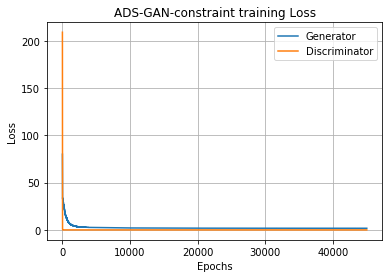

In [15]:
plt.title("ADS-GAN-constraint training Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
# plt.ylim(-3,50)
plt.grid()
plt.plot(losses_gen, label='Generator')
plt.plot(losses_dis, label='Discriminator')
plt.legend(loc='best')
plt.savefig("./ADS-GAN-constraint_LOSS.png",dpi=300)
plt.show()

In [16]:
## create matrix 0 row*latent_dim columns
arr=np.empty((0,latent_dim))
noise = tf.random.normal([128, latent_dim])

## batch testing data
testing_dataset = tf.data.Dataset.from_tensor_slices(X_test.to_numpy())\
        .shuffle(buffer_size).batch(batch_size, drop_remainder=True)

## generate dataset
for data in testing_dataset:
    gen_=generator(noise, data).numpy()
    arr=np.append(arr,gen_,axis=0)
arr.shape

(896, 63)

In [17]:
output_dataset = pd.DataFrame(np.round(sc.inverse_transform(arr)), columns=[
    'BT_NM', 'HR_NM', 'RR_NM', 'HB_NM', 'HCT_NM', 'PLATELET_NM', 'WBC_NM',
    'PTT1_NM', 'PTT2_NM', 'PTINR_NM', 'ER_NM', 'BUN_NM', 'CRE_NM', 'BMI',
    'age', 'PPD', 'THDA_FL', 'THDH_FL', 'THDI_FL', 'THDAM_FL', 'THDV_FL',
    'THDE_FL', 'THDM_FL', 'THDR_FL', 'THDP_FL', 'THDOO_FL', 'Gender',
    'cortical_ACA_ctr', 'cortical_MCA_ctr', 'subcortical_ACA_ctr',
    'subcortical_MCA_ctr', 'PCA_cortex_ctr', 'thalamus_ctr',
    'brainstem_ctr', 'cerebellum_ctr', 'Watershed_ctr',
    'Hemorrhagic_infarct_ctr', 'cortical_ACA_ctl', 'cortical_MCA_ctl',
    'subcortical_ACA_ctl', 'subcortical_MCA_ctl', 'PCA_cortex_ctl',
    'thalamus_ctl', 'brainstem_ctl', 'cerebellum_ctl', 'Watershed_ctl',
    'Hemorrhagic_infarct_ctl', 'NIHS_1a_in', 'NIHS_1b_in', 'NIHS_1c_in',
    'NIHS_2_in', 'NIHS_3_in', 'NIHS_4_in', 'NIHS_5aL_in', 'NIHS_5bR_in',
    'NIHS_6aL_in', 'NIHS_6bR_in', 'NIHS_7_in', 'NIHS_8_in', 'NIHS_9_in',
    'NIHS_10_in', 'NIHS_11_in','elapsed_class'
])
output_dataset

,BT_NM,HR_NM,RR_NM,HB_NM,HCT_NM,PLATELET_NM,WBC_NM,PTT1_NM,PTT2_NM,PTINR_NM,ER_NM,BUN_NM,CRE_NM,BMI,age,PPD,THDA_FL,THDH_FL,THDI_FL,THDAM_FL,THDV_FL,THDE_FL,THDM_FL,THDR_FL,THDP_FL,THDOO_FL,Gender,cortical_ACA_ctr,cortical_MCA_ctr,subcortical_ACA_ctr,subcortical_MCA_ctr,PCA_cortex_ctr,thalamus_ctr,brainstem_ctr,cerebellum_ctr,Watershed_ctr,Hemorrhagic_infarct_ctr,cortical_ACA_ctl,cortical_MCA_ctl,subcortical_ACA_ctl,subcortical_MCA_ctl,PCA_cortex_ctl,thalamus_ctl,brainstem_ctl,cerebellum_ctl,Watershed_ctl,Hemorrhagic_infarct_ctl,NIHS_1a_in,NIHS_1b_in,NIHS_1c_in,NIHS_2_in,NIHS_3_in,NIHS_4_in,NIHS_5aL_in,NIHS_5bR_in,NIHS_6aL_in,NIHS_6bR_in,NIHS_7_in,NIHS_8_in,NIHS_9_in,NIHS_10_in,NIHS_11_in,elapsed_class
0,37.0,54.0,11.0,10.0,42.0,97.0,17.0,31.0,19.0,1.0,359.0,30.0,2.0,20.0,90.0,118.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,37.0,101.0,23.0,12.0,37.0,179.0,8.0,34.0,32.0,1.0,252.0,15.0,2.0,22.0,66.0,75.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,35.0,63.0,14.0,11.0,39.0,536.0,3.0,26.0,46.0,1.0,138.0,19.0,3.0,29.0,59.0,72.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
3,35.0,61.0,15.0,15.0,42.0,283.0,11.0,30.0,21.0,1.0,194.0,12.0,1.0,22.0,57.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,36.0,79.0,16.0,14.0,27.0,308.0,9.0,28.0,18.0,1.0,148.0,22.0,0.0,26.0,67.0,45.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,4.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,37.0,91.0,12.0,16.0,54.0,85.0,12.0,27.0,32.0,1.0,96.0,17.0,0.0,24.0,60.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,3.0,2.0,0.0,0.0
892,36.0,59.0,23.0,13.0,29.0,81.0,9.0,23.0,21.0,2.0,192.0,26.0,1.0,20.0,71.0,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,4.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
893,37.0,113.0,13.0,13.0,41.0,320.0,5.0,33.0,64.0,1.0,129.0,13.0,1.0,22.0,70.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
894,36.0,158.0,16.0,10.0,26.0,133.0,3.0,21.0,40.0,1.0,140.0,17.0,1.0,18.0,93.0,106.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [18]:
output_dataset.to_csv("../dataset/output_dataset/ADS-GAN-constraint_models.csv",encoding='utf_8_sig')

In [19]:
X_TEST_dataset = pd.DataFrame(np.round(sc.inverse_transform(X_test)), columns=[
    'BT_NM', 'HR_NM', 'RR_NM', 'HB_NM', 'HCT_NM', 'PLATELET_NM', 'WBC_NM',
    'PTT1_NM', 'PTT2_NM', 'PTINR_NM', 'ER_NM', 'BUN_NM', 'CRE_NM', 'BMI',
    'age', 'PPD', 'THDA_FL', 'THDH_FL', 'THDI_FL', 'THDAM_FL', 'THDV_FL',
    'THDE_FL', 'THDM_FL', 'THDR_FL', 'THDP_FL', 'THDOO_FL', 'Gender',
    'cortical_ACA_ctr', 'cortical_MCA_ctr', 'subcortical_ACA_ctr',
    'subcortical_MCA_ctr', 'PCA_cortex_ctr', 'thalamus_ctr',
    'brainstem_ctr', 'cerebellum_ctr', 'Watershed_ctr',
    'Hemorrhagic_infarct_ctr', 'cortical_ACA_ctl', 'cortical_MCA_ctl',
    'subcortical_ACA_ctl', 'subcortical_MCA_ctl', 'PCA_cortex_ctl',
    'thalamus_ctl', 'brainstem_ctl', 'cerebellum_ctl', 'Watershed_ctl',
    'Hemorrhagic_infarct_ctl', 'NIHS_1a_in', 'NIHS_1b_in', 'NIHS_1c_in',
    'NIHS_2_in', 'NIHS_3_in', 'NIHS_4_in', 'NIHS_5aL_in', 'NIHS_5bR_in',
    'NIHS_6aL_in', 'NIHS_6bR_in', 'NIHS_7_in', 'NIHS_8_in', 'NIHS_9_in',
    'NIHS_10_in', 'NIHS_11_in','elapsed_class'
])
X_TEST_dataset.to_csv("../dataset/output_dataset/ADS-GAN-constraint_XTEST.csv",encoding='utf_8_sig')

In [20]:
## release the memory of gpu
tf.keras.backend.clear_session()
device = cuda.get_current_device()
device.reset()